# **IMPORTS**

In [ ]:
# Instala las últimas versiones de TensorFlow y Keras
!pip install --upgrade tensorflow keras

# Importación de bibliotecas estándar
import os  # Para interactuar con el sistema operativo
import random  # Para generar números aleatorios
import shutil  # Para operaciones de archivo y directorio
import glob  # Para buscar archivos en el sistema de archivos

# Importación de bibliotecas para manejo de datos y operaciones numéricas
import numpy as np  # Para operaciones numéricas
import pandas as pd  # Para manejo de datos en forma de DataFrame (opcional, en caso de que lo necesites)

# Importación de bibliotecas para visualización
import matplotlib.pyplot as plt  # Para crear gráficos
import seaborn as sns  # Para visualización estadística
sns.set_style('darkgrid')  # Establece el estilo de los gráficos a 'darkgrid'

# Importación de bibliotecas de aprendizaje automático
from sklearn.preprocessing import LabelEncoder, OneHotEncoder  # Para codificar etiquetas
from sklearn.model_selection import train_test_split  # Para dividir los datos en conjuntos de entrenamiento y prueba
from sklearn.metrics import confusion_matrix, classification_report  # Para evaluar el rendimiento del modelo

# Importación de bibliotecas para procesamiento de imágenes
from PIL import Image  # Para abrir y manipular imágenes

# Importación de TensorFlow y Keras
import tensorflow as tf  # Biblioteca principal para el aprendizaje profundo
from tensorflow import keras  # API de alto nivel para construir y entrenar modelos
from keras.models import Sequential  # Para crear modelos secuenciales
from keras.layers import Dense, BatchNormalization, Dropout, Flatten, MaxPooling2D, Conv2D, Activation  # Para construir capas de la red neuronal
from tensorflow.keras.callbacks import EarlyStopping  # Para detener el entrenamiento temprano si no hay mejora

# Importación de Kaggle Hub para descargar conjuntos de datos
import kagglehub  # Biblioteca para interactuar con Kaggle

# Descarga la última versión del conjunto de datos de reconocimiento de emociones
path = kagglehub.dataset_download("sujaykapadnis/emotion-recognition-dataset")  # Descarga el conjunto de datos especificado

# Imprime la ruta a los archivos del conjunto de datos
print("Path to dataset files:", path)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 69.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 109.6 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.0
    Uninstalling tensorboard-2.17.0:
      Successfully uninstalled tensorboard-2.17.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.0
    Uninstalling tensorflow-2.17.0:
      Successfully uninstalled tensorflow-2.17.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompa

100%|██████████| 1.98G/1.98G [01:35<00:00, 22.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sujaykapadnis/emotion-recognition-dataset/versions/1


# **CARGAR DATASET**

Le permite al usuario listar las subcarpetas dentro de un directorio determinado y contar la cantidad de imágenes que se encuentran en cada una de estas subcarpetas. Al ejecutar la función list_subfolders, se verifica primero la existencia de la ruta especificada. Si la ruta es válida, el programa identifica todas las subcarpetas y cuenta cuántas imágenes de formatos comunes (JPG, JPEG, PNG) hay en cada una de ellas. Esto resulta útil para tener una visión general de la estructura del conjunto de datos y la cantidad de imágenes disponibles para cada categoría de emociones, facilitando así el análisis y la preparación de datos para tareas de aprendizaje automático o procesamiento de imágenes. En caso de que la ruta no sea válida, se proporciona un mensaje de error, lo que asegura que el usuario esté informado sobre el estado de la operación.

In [ ]:
# Ruta del directorio que quieres explorar
dataset_path = "/root/.cache/kagglehub/datasets/sujaykapadnis/emotion-recognition-dataset/versions/1/dataset"

# Función para listar solo las subcarpetas en el directorio dado
def list_subfolders(path):
    # Verifica si la ruta existe
    if os.path.exists(path):
        # Lista las subcarpetas en el directorio especificado
        subfolders = [f.name for f in os.scandir(path) if f.is_dir()]
        print("Subcarpetas encontradas:", subfolders)

        # Contar imágenes en cada subcarpeta
        for folder in subfolders:
            folder_path = os.path.join(path, folder)  # Construye la ruta completa de la subcarpeta
            # Cuenta el número de imágenes en la subcarpeta que tienen extensiones específicas
            image_count = sum(1 for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png')))
            print(f"Número de imágenes en '{folder}': {image_count}")  # Imprime el conteo de imágenes
    else:
        print("La ruta no existe.")  # Mensaje de error si la ruta no es válida

# Ejecuta la función para listar subcarpetas y contar imágenes
list_subfolders(dataset_path)

Subcarpetas encontradas: ['Angry', 'Neutral', 'Surprise', 'Happy', 'Ahegao', 'Sad']
Número de imágenes en 'Angry': 1312
Número de imágenes en 'Neutral': 4025
Número de imágenes en 'Surprise': 1234
Número de imágenes en 'Happy': 3739
Número de imágenes en 'Ahegao': 1205
Número de imágenes en 'Sad': 3933


# **BALANCEAR CATEGORIAS**

implementamos un proceso para aumentar el número de imágenes en un conjunto de datos sobre emociones, asegurando que cada categoría tenga un número objetivo de imágenes (en este caso, 4025). Comienza verificando la existencia de un directorio de salida para almacenar las imágenes aumentadas y, si no existe, lo crea. Luego, itera sobre las subcarpetas del conjunto de datos original, omitiendo la carpeta 'Ahegao' y aquellas que no son directorios.

Para cada categoría, copia las imágenes originales en el directorio de salida y aplica técnicas de aumento de imágenes, como rotación aleatoria y espejado, hasta alcanzar el número objetivo de imágenes. Las imágenes aumentadas se guardan con un nombre único para evitar conflictos. Al finalizar el procesamiento de cada categoría, se imprime el número total de imágenes en la carpeta de salida, y al concluir todo el proceso, se muestra un mensaje final indicando que el aumento ha sido completado

In [ ]:
# Importación de bibliotecas necesarias
from PIL import Image, ImageOps  # Para manipulación de imágenes
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Para generación de datos de imágenes (no se usa en este fragmento)

# Rutas de los directorios
original_path = "/root/.cache/kagglehub/datasets/sujaykapadnis/emotion-recognition-dataset/versions/1/dataset"  # Ruta del conjunto de datos original
output_path = "/content/filtered_emotion_dataset"  # Ruta donde se guardarán las imágenes aumentadas

# Crear el nuevo directorio si no existe
if not os.path.exists(output_path):  # Verifica si el directorio de salida ya existe
    os.makedirs(output_path)  # Crea el directorio de salida

# Función para aumentar imágenes con técnicas de rotación, espejado, etc.
def augment_image(image):
    # Lista de transformaciones que se pueden aplicar a la imagen
    augmentations = [
        lambda x: x.rotate(random.randint(-30, 30)),  # Rotación aleatoria entre -30 y 30 grados
        lambda x: ImageOps.mirror(x),  # Espejado horizontal de la imagen
        lambda x: x.transpose(Image.FLIP_TOP_BOTTOM)  # Espejado vertical de la imagen
    ]
    # Selecciona aleatoriamente una de las transformaciones y la aplica a la imagen
    return random.choice(augmentations)(image)

# Configurar el aumento para cada subcarpeta (categoría)
target_count = 4025  # Número objetivo de imágenes por categoría (nivelado al máximo de imágenes de la categoría 'Neutral')

# Iterar sobre cada carpeta en el directorio original
for folder in os.listdir(original_path):
    folder_path = os.path.join(original_path, folder)  # Construye la ruta completa de la subcarpeta

    # Omitir la carpeta 'Ahegao' y verificar si es una carpeta
    if folder == 'Ahegao' or not os.path.isdir(folder_path):
        continue  # Si es 'Ahegao' o no es un directorio, se omite

    output_folder = os.path.join(output_path, folder)  # Ruta de salida para la categoría actual
    os.makedirs(output_folder, exist_ok=True)  # Crea la carpeta de salida si no existe

    # Copiar imágenes originales al nuevo directorio
    images = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]  # Lista de imágenes en la carpeta
    for image_file in images:
        # Copia cada imagen original al directorio de salida
        shutil.copy(os.path.join(folder_path, image_file), output_folder)

    # Aumentar hasta alcanzar el objetivo
    while len(os.listdir(output_folder)) < target_count:  # Mientras el número de imágenes en la carpeta de salida sea menor que el objetivo
        image_file = random.choice(images)  # Selecciona aleatoriamente una imagen de la lista
        image_path = os.path.join(folder_path, image_file)  # Construye la ruta completa de la imagen

        # Abrir y aplicar transformación
        with Image.open(image_path) as img:  # Abre la imagen
            augmented_img = augment_image(img)  # Aplica la función de aumento
            # Genera un nombre de archivo único para la imagen aumentada
            augmented_filename = f"aug_{random.randint(10000, 99999)}_{image_file}"
            # Guarda la imagen aumentada en el directorio de salida
            augmented_img.save(os.path.join(output_folder, augmented_filename))

    # Imprime el número de imágenes procesadas en la categoría actual
    print(f"Categoría '{folder}' procesada con {len(os.listdir(output_folder))} imágenes.")

# Mensaje final indicando que el proceso de aumento ha finalizado
print("Proceso de aumento completado.")

Categoría 'Angry' procesada con 4025 imágenes.
Categoría 'Neutral' procesada con 4025 imágenes.
Categoría 'Surprise' procesada con 4025 imágenes.
Categoría 'Happy' procesada con 4025 imágenes.
Categoría 'Sad' procesada con 4025 imágenes.
Proceso de aumento completado.


# **LISTAR DATOS**

permite explorar un directorio dado para identificar sus subcarpetas y contar las imágenes que contienen. Al ejecutar esta función, primero se verifica si la ruta especificada existe; si es así, se listan todas las subcarpetas y se imprime su nombre. Luego, para cada subcarpeta, se cuenta el número de imágenes con extensiones comunes (JPG, JPEG, PNG) y se imprime este conteo, proporcionando así una visión clara de la distribución de imágenes en las diferentes categorías.

Si la ruta no existe, se notifica al usuario mediante un mensaje de error. Este script es útil para realizar un seguimiento y análisis del contenido de un directorio de salida, especialmente después de haber realizado un proceso de aumento de imágenes, permitiendo al usuario verificar la efectividad del aumento y la organización del conjunto de datos.

In [ ]:
# Función para listar solo las subcarpetas en el directorio dado
def list_subfolders(path):
    # Verifica si la ruta existe
    if os.path.exists(path):
        # Lista las subcarpetas en el directorio especificado
        subfolders = [f.name for f in os.scandir(path) if f.is_dir()]
        print("Subcarpetas encontradas:", subfolders)  # Imprime las subcarpetas encontradas

        # Contar imágenes en cada subcarpeta
        for folder in subfolders:
            folder_path = os.path.join(path, folder)  # Construye la ruta completa de la subcarpeta
            # Cuenta el número de imágenes en la subcarpeta que tienen extensiones específicas
            image_count = sum(1 for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png')))
            print(f"Número de imágenes en '{folder}': {image_count}")  # Imprime el conteo de imágenes en la subcarpeta
    else:
        print("La ruta no existe.")  # Mensaje de error si la ruta no es válida

# Ejecuta la función para listar subcarpetas y contar imágenes en el directorio de salida
list_subfolders(output_path)

Subcarpetas encontradas: ['Angry', 'Neutral', 'Surprise', 'Happy', 'Sad']
Número de imágenes en 'Angry': 4025
Número de imágenes en 'Neutral': 4025
Número de imágenes en 'Surprise': 4025
Número de imágenes en 'Happy': 4025
Número de imágenes en 'Sad': 4025


# **IMAGENES DE MUESTRA**

explorar un directorio dado para identificar sus subcarpetas y visualizar ejemplos de imágenes contenidas en cada una de ellas. Al ejecutar la función, se verifica la existencia de la ruta especificada; si es válida, se listan todas las subcarpetas imprimiendose la cantidad de imágenes que hay en cada una.

Para cada subcarpeta se selecciona aleatoriamente hasta cinco imágenes y las muestra utilizando la biblioteca Matplotlib proprcionando una visualización clara y accesible de los ejemplos de cada clase, lo que puede ser útil para la revisión del conjunto de datos y para entender mejor la distribución y variedad de las imágenes en las diferentes categorías. Si la ruta no es válida, se notifica al usuario con un mensaje de error. Este enfoque es especialmente valioso en el contexto de la preparación de datos para modelos de aprendizaje automático, ya que permite evaluar visualmente la calidad y diversidad del conjunto de datos

Subcarpetas encontradas: ['Angry', 'Neutral', 'Surprise', 'Happy', 'Sad']
Número de imágenes en 'Angry': 4025


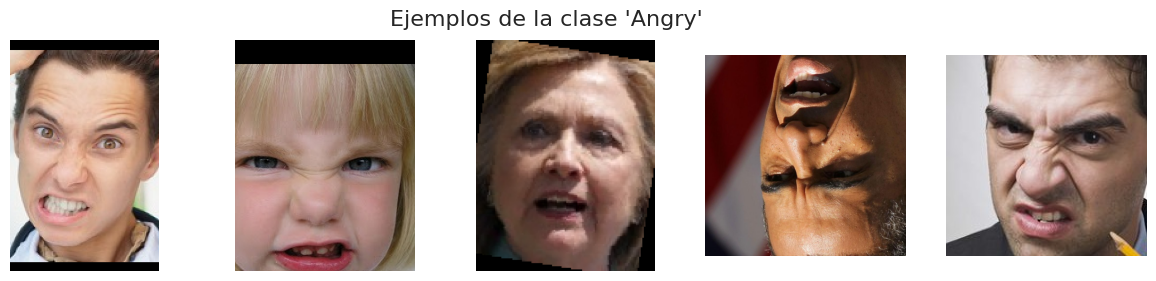

Número de imágenes en 'Neutral': 4025


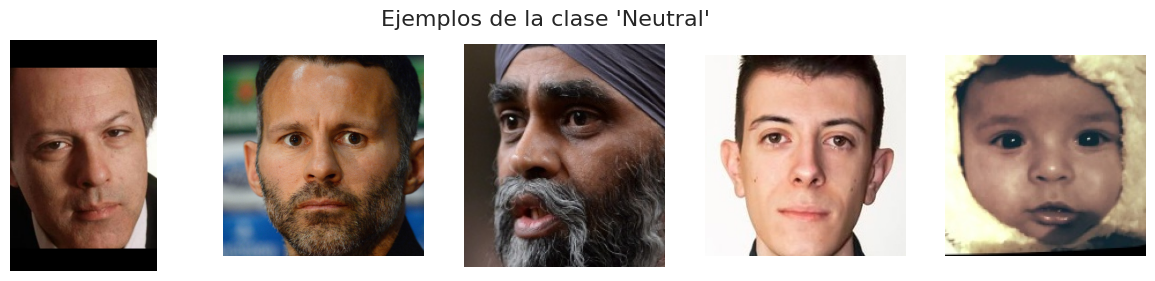

Número de imágenes en 'Surprise': 4025


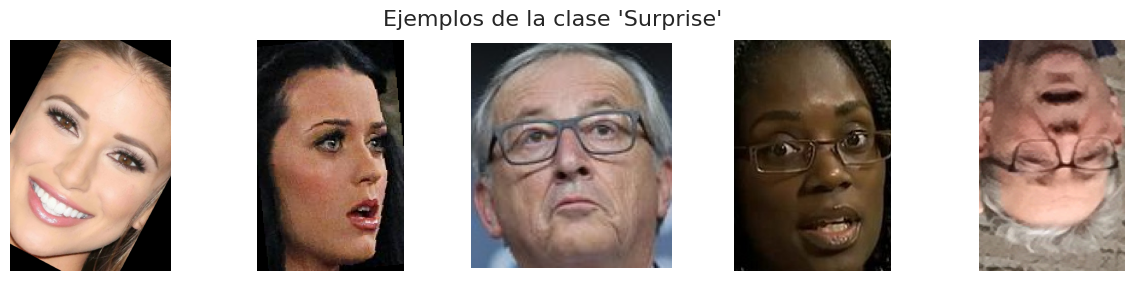

Número de imágenes en 'Happy': 4025


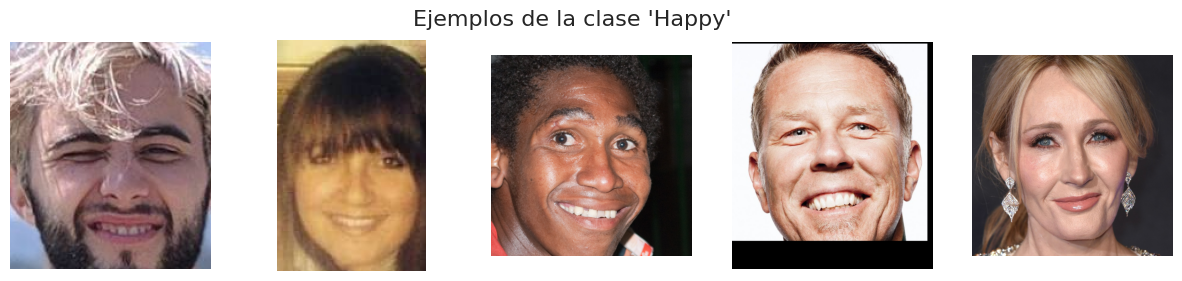

Número de imágenes en 'Sad': 4025


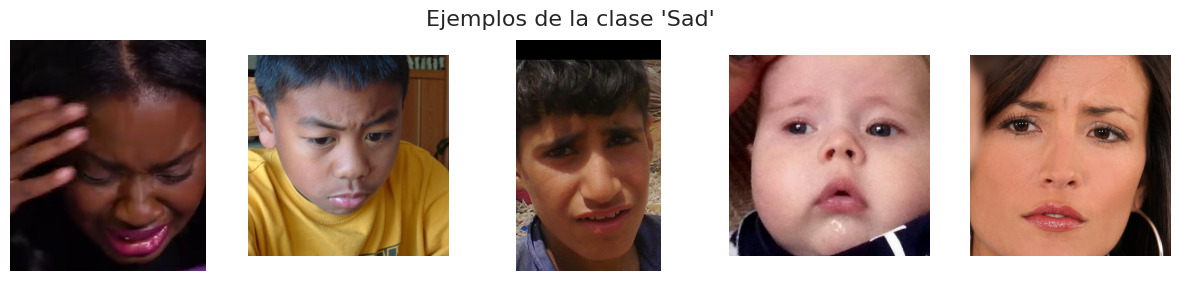

In [ ]:
# Importación de bibliotecas necesarias
import os  # Para interactuar con el sistema de archivos
import random  # Para seleccionar imágenes aleatorias
import matplotlib.pyplot as plt  # Para visualizar imágenes
from PIL import Image  # Para manipulación de imágenes

# Función para listar solo las subcarpetas en el directorio dado y mostrar 5 imágenes por clase
def list_subfolders_and_show_images(path):
    # Verifica si la ruta existe
    if os.path.exists(path):
        # Lista las subcarpetas en el directorio especificado
        subfolders = [f.name for f in os.scandir(path) if f.is_dir()]
        print("Subcarpetas encontradas:", subfolders)  # Imprime las subcarpetas encontradas

        # Contar imágenes en cada subcarpeta y mostrar algunas de ellas
        for folder in subfolders:
            folder_path = os.path.join(path, folder)  # Construye la ruta completa de la subcarpeta
            # Lista las imágenes en la subcarpeta que tienen extensiones específicas
            images = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            image_count = len(images)  # Cuenta el número de imágenes
            print(f"Número de imágenes en '{folder}': {image_count}")  # Imprime el conteo de imágenes

            # Seleccionar hasta 5 imágenes aleatorias de esta clase
            sample_images = random.sample(images, min(5, image_count))  # Selecciona aleatoriamente hasta 5 imágenes

            # Mostrar las imágenes
            plt.figure(figsize=(15, 3))  # Crea una figura para mostrar las imágenes
            plt.suptitle(f"Ejemplos de la clase '{folder}'", fontsize=16)  # Título de la figura
            for i, image_name in enumerate(sample_images):
                image_path = os.path.join(folder_path, image_name)  # Construye la ruta completa de la imagen
                img = Image.open(image_path)  # Abre la imagen
                plt.subplot(1, 5, i + 1)  # Crea un subplot para cada imagen
                plt.imshow(img)  # Muestra la imagen
                plt.axis('off')  # Oculta los ejes
            plt.show()  # Muestra la figura con las imágenes
    else:
        print("La ruta no existe.")  # Mensaje de error si la ruta no es válida

# Ejecuta la función para listar subcarpetas y mostrar imágenes
list_subfolders_and_show_images(output_path)

# **CARGA Y PREPOCESAMIENTO DE IMAGENES PARA EL MODELO**

procesamos las imágenes de las cinco clases emocionales (Angry, Happy, Neutral, Sad y Surprise) al recorrer sus respectivos directorios, redimensionarlas a 128x128 píxeles y convertirlas a arrays de NumPy. Utiliza la codificación one-hot para etiquetar cada imagen, asegurando que las etiquetas estén correctamente asignadas y estructuradas. Al final, se generan arrays de NumPy tanto para las imágenes como para las etiquetas, listos para ser utilizados en modelos de aprendizaje automático. Este proceso es esencial para la preparación de datos en tareas de clasificación de imágenes, garantizando que las entradas y salidas estén en el formato adecuado para el entrenamiento del modelo

Al final, se muestra la forma del array de datos y se asegura que el array de etiquetas tenga la dimensión correcta

In [ ]:
encoder=OneHotEncoder()

encoder.fit([[0],[1],[2],[3],[4]])

OneHotEncoder()

In [ ]:
# Inicialización de listas para almacenar datos de imágenes y sus etiquetas
data = []  # Lista para almacenar las imágenes procesadas
paths = []  # Lista para almacenar las rutas de las imágenes
result = []  # Lista para almacenar las etiquetas correspondientes a las imágenes

# Recorre el directorio de la clase 'Angry' para obtener las rutas de las imágenes
for r, d, f in os.walk(output_path + '/Angry'):
    for file in f:
        # Verifica si el archivo tiene una extensión de imagen válida
        if file.endswith('.jpg') or file.endswith('.png'):
            paths.append(os.path.join(r, file))  # Agrega la ruta completa del archivo a la lista

# Procesa cada imagen en la lista de rutas
for path in paths:
    img = Image.open(path)  # Abre la imagen
    img = img.resize((128, 128))  # Redimensiona la imagen a 128x128 píxeles
    img = np.array(img)  # Convierte la imagen a un array de NumPy

    # Verifica si la imagen tiene la forma correcta (128, 128, 3)
    if img.shape == (128, 128, 3):
        data.append(np.array(img))  # Agrega la imagen procesada a la lista de datos
        result.append(encoder.transform([[0]]).toarray())  # Agrega la etiqueta correspondiente (en este caso, '0') a la lista de resultados

In [ ]:
# Inicialización de la lista para almacenar las rutas de las imágenes
paths = []

# Recorre el directorio de la clase 'Happy' para obtener las rutas de las imágenes
for r, d, f in os.walk(output_path + '/Happy'):
    for file in f:
        # Verifica si el archivo tiene una extensión de imagen válida
        if file.endswith('.jpg') or file.endswith('.png'):
            paths.append(os.path.join(r, file))  # Agrega la ruta completa del archivo a la lista

# Procesa cada imagen en la lista de rutas
for path in paths:
    img = Image.open(path)  # Abre la imagen
    img = img.resize((128, 128))  # Redimensiona la imagen a 128x128 píxeles
    img = np.array(img)  # Convierte la imagen a un array de NumPy

    # Verifica si la imagen tiene la forma correcta (128, 128, 3)
    if img.shape == (128, 128, 3):
        data.append(np.array(img))  # Agrega la imagen procesada a la lista de datos
        result.append(encoder.transform([[1]]).toarray())  # Agrega la etiqueta correspondiente (en este caso, '1') a la lista de resultados

In [ ]:
# Inicialización de la lista para almacenar las rutas de las imágenes
paths = []

# Recorre el directorio de la clase 'Neutral' para obtener las rutas de las imágenes
for r, d, f in os.walk(output_path + '/Neutral'):
    for file in f:
        # Verifica si el archivo tiene una extensión de imagen válida
        if file.endswith('.jpg') or file.endswith('.png'):
            paths.append(os.path.join(r, file))  # Agrega la ruta completa del archivo a la lista

# Procesa cada imagen en la lista de rutas
for path in paths:
    img = Image.open(path)  # Abre la imagen
    img = img.resize((128, 128))  # Redimensiona la imagen a 128x128 píxeles
    img = np.array(img)  # Convierte la imagen a un array de NumPy

    # Verifica si la imagen tiene la forma correcta (128, 128, 3)
    if img.shape == (128, 128, 3):
        data.append(np.array(img))  # Agrega la imagen procesada a la lista de datos
        result.append(encoder.transform([[2]]).toarray())  # Agrega la etiqueta correspondiente (en este caso, '2') a la lista de resultados

In [ ]:
# Inicialización de la lista para almacenar las rutas de las imágenes
paths = []

# Recorre el directorio de la clase 'Sad' para obtener las rutas de las imágenes
for r, d, f in os.walk(output_path + '/Sad'):
    for file in f:
        # Verifica si el archivo tiene una extensión de imagen válida
        if file.endswith('.jpg') or file.endswith('.png'):
            paths.append(os.path.join(r, file))  # Agrega la ruta completa del archivo a la lista

# Procesa cada imagen en la lista de rutas
for path in paths:
    img = Image.open(path)  # Abre la imagen
    img = img.resize((128, 128))  # Redimensiona la imagen a 128x128 píxeles
    img = np.array(img)  # Convierte la imagen a un array de NumPy

    # Verifica si la imagen tiene la forma correcta (128, 128, 3)
    if img.shape == (128, 128, 3):
        data.append(np.array(img))  # Agrega la imagen procesada a la lista de datos
        result.append(encoder.transform([[3]]).toarray())  # Agrega la etiqueta correspondiente (en este caso, '3') a la lista de resultados

In [ ]:
# Inicialización de la lista para almacenar las rutas de las imágenes
paths = []

# Recorre el directorio de la clase 'Surprise' para obtener las rutas de las imágenes
for r, d, f in os.walk(output_path + '/Surprise'):
    for file in f:
        # Verifica si el archivo tiene una extensión de imagen válida
        if file.endswith('.jpg') or file.endswith('.png'):
            paths.append(os.path.join(r, file))  # Agrega la ruta completa del archivo a la lista

# Procesa cada imagen en la lista de rutas
for path in paths:
    img = Image.open(path)  # Abre la imagen
    img = img.resize((128, 128))  # Redimensiona la imagen a 128x128 píxeles
    img = np.array(img)  # Convierte la imagen a un array de NumPy

    # Verifica si la imagen tiene la forma correcta (128, 128, 3)
    if img.shape == (128, 128, 3):
        data.append(np.array(img))  # Agrega la imagen procesada a la lista de datos
        result.append(encoder.transform([[4]]).toarray())  # Agrega la etiqueta correspondiente (en este caso, '4') a la lista de resultados

In [ ]:
# Convierte la lista de datos a un array de NumPy
data = np.array(data)

# Muestra la forma del array de datos
data.shape

(20125, 128, 128, 3)

In [ ]:
# Convierte la lista de resultados a un array de NumPy
result = np.array(result)

# Redimensiona el array de resultados a la forma (20125, 5)
result = result.reshape(20125, 5)

# **DIVISION DEL CONJUNTO DE DATOS - TRAIN Y TEST**

realizamos la división del conjunto de datos de imágenes en conjuntos de entrenamiento y prueba utilizando la función train_test_split, de esa forma reservamos el 20% de los datos para pruebas. Luego, imprime la cantidad de imágenes en cada conjunto para proporcionar una visión clara de la distribución de los datos. Para visualizar esta partición, se genera un gráfico de pastel que muestra la proporción de imágenes en los conjuntos de entrenamiento y prueba, con un diseño atractivo que destaca el conjunto de entrenamiento. Esta visualización es útil para entender cómo se distribuyen los datos, lo que es crucial para evaluar la efectividad del modelo de aprendizaje automático que se entrenará posteriormente.

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(data,result,test_size=0.2,shuffle=True,random_state=0)

Número de imágenes en el conjunto de entrenamiento: 16100
Número de imágenes en el conjunto de prueba: 4025


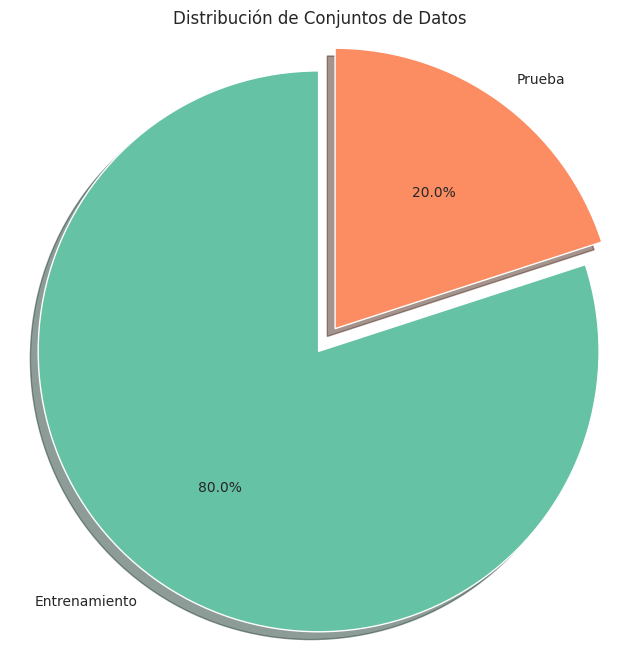

In [ ]:
# Imprimir cuántas imágenes hay en cada conjunto
print(f"Número de imágenes en el conjunto de entrenamiento: {len(x_train)}")
print(f"Número de imágenes en el conjunto de prueba: {len(x_test)}")

# Crear un gráfico de pastel para visualizar la partición
labels = ['Entrenamiento', 'Prueba']  # Etiquetas para las secciones del gráfico
sizes = [len(x_train), len(x_test)]  # Tamaños de cada sección basados en la cantidad de imágenes
colors = ['#66c2a5', '#fc8d62']  # Colores para cada sección del gráfico
explode = (0.1, 0)  # "Explotar" la primera sección (Entrenamiento) para destacarla

# Configuración del gráfico
plt.figure(figsize=(8, 8))  # Establece el tamaño de la figura
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)  # Crea el gráfico de pastel
plt.axis('equal')  # Asegura que el gráfico de pastel se dibuje como un círculo
plt.title('Distribución de Conjuntos de Datos')  # Título del gráfico
plt.show()  # Muestra el gráfico

# **CREACION DEL MODELO**

establecemos un modelo de red neuronal utilizando la arquitectura preentrenada ResNet152 como base, adaptándola para una tarea de clasificación de imágenes en cinco categorías. Al excluir las capas superiores y aplicar max pooling, se optimiza el modelo para extraer características relevantes de las imágenes de entrada. Se construye una serie de capas densas con activación ReLU, intercaladas con capas de normalización y dropout, lo que ayuda a estabilizar el aprendizaje y mitigar el riesgo de sobreajuste.

La compilación del modelo se realiza utilizando la función de pérdida de entropía cruzada categórica y el optimizador Adamax, lo que es adecuado para problemas de clasificación multiclase. La implementación de EarlyStopping permite detener el entrenamiento si no se observan mejoras en la precisión del conjunto de validación, asegurandonos que se utilicen los mejores pesos del modelo

In [ ]:
# Cargar el modelo base preentrenado ResNet152 sin las capas superiores
base_model = tf.keras.applications.ResNet152(
    include_top=False,          # No incluir las capas superiores (de clasificación)
    weights="imagenet",         # Cargar los pesos preentrenados en ImageNet
    input_shape=(128, 128, 3),  # Definir la forma de entrada de las imágenes
    pooling='max'               # Usar max pooling para la salida
)

# Construir el modelo secuencial
model = Sequential([
    base_model,                # Agregar el modelo base
    Flatten(),                 # Aplanar la salida del modelo base

    # Primera capa densa con normalización y dropout
    BatchNormalization(),      # Normalización de lotes para estabilizar el aprendizaje
    Dense(300, activation='relu'),  # Capa densa con 300 neuronas y activación ReLU
    Dropout(0.5),             # Capa de dropout para prevenir el sobreajuste

    # Segunda capa densa
    Dense(400, activation='relu'),  # Capa densa con 400 neuronas y activación ReLU
    Dropout(0.5),             # Capa de dropout

    # Tercera capa densa
    Dense(500, activation='relu'),  # Capa densa con 500 neuronas y activación ReLU
    Dropout(0.5),             # Capa de dropout

    # Cuarta capa densa
    Dense(600, activation='relu'),  # Capa densa con 600 neuronas y activación ReLU
    Dropout(0.5),             # Capa de dropout

    # Quinta capa densa, con menos neuronas para regularización antes de la salida
    Dense(400, activation='relu'),  # Capa densa con 400 neuronas y activación ReLU
    Dropout(0.5),             # Capa de dropout

    # Capa de salida con activación softmax para clasificación de 5 categorías
    Dense(5, activation='softmax')  # Capa de salida con 5 neuronas (una por clase) y activación softmax
])

# Compilar el modelo
model.compile(
    loss='categorical_crossentropy',   # Función de pérdida para clasificación multiclase
    optimizer='Adamax',                # Optimizador Adamax
    metrics=['accuracy']               # Métrica a monitorear durante el entrenamiento
)

# Configuración de EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',            # Métrica a monitorear (precisión en el conjunto de validación)
    patience=7,                        # Número de épocas sin mejora antes de detener el entrenamiento
    restore_best_weights=True          # Restaurar los mejores pesos alcanzados durante el entrenamiento
)

# Mostrar el resumen del modelo
model.summary()  # Imprime un resumen de la arquitectura del modelo

234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet152 (Functional)               │ (None, 2048)                │      58,370,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 300)                 │         614,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 400)                 │         120,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 400)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 500)                 │         200,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 600)                 │         300,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 600)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 400)                 │         240,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 400)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │           2,005 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 59,857,741 (228.34 MB)

 Trainable params: 59,702,221 (227.75 MB)

 Non-trainable params: 155,520 (607.50 KB)

# **ENTRENAMIENTO**

Implementamos un proceso de entrenamiento robusto y optimizado, que no solo se enfoca en ajustar el modelo a los datos de entrenamiento, sino que también prioriza la validación continua y la prevención del sobreajuste, lo que es fundamental para desarrollar un modelo efectivo y generalizable en la clasificación de imágenes. Originalmente 40 epocas pero al tener early_stopping se detuvo en la epoca 34 con un patience de 7 y restaurando los mejores pesos alcanzados.

* Mejora inicial: Al principio, el modelo tiene baja precisión en el conjunto de entrenamiento y validación (épocas 1-6), pero luego muestra un aumento progresivo en ambas, alcanzando el 80% de precisión en validación hacia la época 20. Esta es una señal de que el modelo está mejorando en su capacidad para generalizar.

* Problemas de sobreajuste: Después de la época 20, la pérdida de validación comienza a ser inconsistente y a aumentar, mientras que la precisión en el conjunto de entrenamiento continúa mejorando. Este es un signo de sobreajuste. La pérdida en validación es alta (por encima de 1) desde la época 27 en adelante, lo que sugiere que el modelo podría estar ajustándose demasiado a los datos de entrenamiento y perdiendo generalización.

Debemos verificar como le fue en la matriz de confusion para librar sospechas.

In [ ]:
# Entrenar el modelo con EarlyStopping
history1 = model.fit(
    x_train,                # Datos de entrenamiento
    y_train,                # Etiquetas de entrenamiento
    epochs=40,              # Número máximo de épocas para entrenar
    batch_size=100,         # Tamaño del lote para el entrenamiento
    verbose=1,              # Nivel de verbosidad (1 muestra el progreso del entrenamiento)
    validation_data=(x_test, y_test),  # Datos y etiquetas para validación
    callbacks=[early_stopping]  # Agregar EarlyStopping en los callbacks
)

Epoch 1/40
161/161 ━━━━━━━━━━━━━━━━━━━━ 287s 830ms/step - accuracy: 0.2015 - loss: 1.8766 - val_accuracy: 0.2229 - val_loss: 456.3581
Epoch 2/40
161/161 ━━━━━━━━━━━━━━━━━━━━ 121s 752ms/step - accuracy: 0.2021 - loss: 1.6951 - val_accuracy: 0.2437 - val_loss: 1.6068
Epoch 3/40
161/161 ━━━━━━━━━━━━━━━━━━━━ 142s 756ms/step - accuracy: 0.2132 - loss: 1.6317 - val_accuracy: 0.2678 - val_loss: 1.6080
Epoch 4/40
161/161 ━━━━━━━━━━━━━━━━━━━━ 144s 769ms/step - accuracy: 0.2370 - loss: 1.6036 - val_accuracy: 0.2976 - val_loss: 1.5562
Epoch 5/40
161/161 ━━━━━━━━━━━━━━━━━━━━ 142s 771ms/step - accuracy: 0.2789 - loss: 1.5489 - val_accuracy: 0.3322 - val_loss: 1.4681
Epoch 6/40
161/161 ━━━━━━━━━━━━━━━━━━━━ 140s 758ms/step - accuracy: 0.3106 - loss: 1.4754 - val_accuracy: 0.3344 - val_loss: 1.3866
Epoch 7/40
161/161 ━━━━━━━━━━━━━━━━━━━━ 142s 756ms/step - accuracy: 0.3540 - loss: 1.3813 - val_accuracy: 0.3240 - val_loss: 1.4626
Epoch 8/40
161/161 ━━━━━━━━━━━━━━━━━━━━ 144s 770ms/step - accuracy: 0.3778

# **MATRIZ DE CONFUSION**

Se muestran los resultados de un modelo de clasificación de emociones, evaluado a través de una matriz de confusión y un reporte de métricas de rendimiento. La matriz de confusión indica cuántas veces el modelo clasificó correctamente o incorrectamente las emociones, mostrando que "Happy" es la emoción que más veces fue correctamente identificada, mientras que "Sad" es la que más confusiones generó, con clasificaciones incorrectas en varias ocasiones. En cuanto al reporte de métricas, se incluyen tres indicadores: precisión, recall y F1-score. Estos valores nos indican que el modelo es bastante preciso en clasificar "Happy" y "Surprise", con un F1-score de 0.91 y 0.89 respectivamente, lo que significa que el modelo tiene un buen rendimiento en estas emociones. Sin embargo, para "Sad" y "Neutral", los valores de F1-score son más bajos (0.65 y 0.72), señalando que estas emociones presentan más dificultad para ser correctamente clasificadas. En general, el modelo tiene una precisión promedio del 81%, lo que indica que logra predecir correctamente las emociones en el 81% de los casos, aunque hay margen de mejora, especialmente en emociones como "Sad" y "Neutral" para aumentar la efectividad global del modelo. Este fallo en Sad y Neutral tambien puede deberse a la calidad del dataset, ya que analizandolo a mano nos dimos cuenta de que hasta nosotros mismos nos equivocabamos en la clasificacion, debido a que son imagenes muy parecidas.

126/126 ━━━━━━━━━━━━━━━━━━━━ 29s 146ms/step


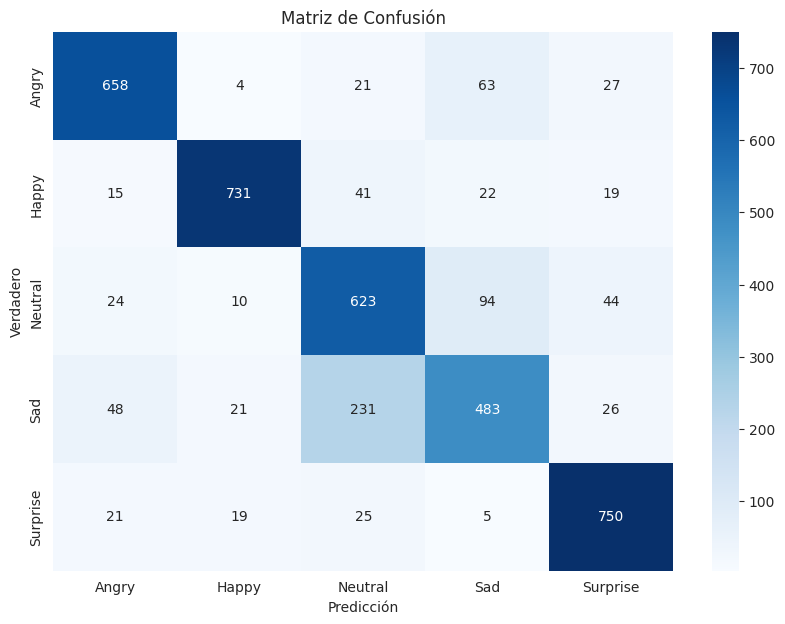

              precision    recall  f1-score   support

       Angry       0.86      0.85      0.86       773
       Happy       0.93      0.88      0.91       828
     Neutral       0.66      0.78      0.72       795
         Sad       0.72      0.60      0.65       809
    Surprise       0.87      0.91      0.89       820

    accuracy                           0.81      4025
   macro avg       0.81      0.81      0.80      4025
weighted avg       0.81      0.81      0.81      4025



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Hacer predicciones
y_pred = model.predict(x_test)  # Realizar predicciones sobre el conjunto de prueba

# Convertir las predicciones a etiquetas
y_pred_classes = np.argmax(y_pred, axis=1)  # Obtener las clases predichas (índices de la clase con mayor probabilidad)
y_true_classes = np.argmax(y_test, axis=1)  # Obtener las clases verdaderas (índices de la clase real)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)  # Calcular la matriz de confusión

# Mostrar la matriz de confusión
plt.figure(figsize=(10, 7))  # Establecer el tamaño de la figura
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
             xticklabels=['Angry', 'Happy', 'Neutral', 'Sad', 'Surprise'],
             yticklabels=['Angry', 'Happy', 'Neutral', 'Sad', 'Surprise'])  # Crear un mapa de calor para la matriz de confusión
plt.ylabel('Verdadero')  # Etiqueta del eje y
plt.xlabel('Predicción')  # Etiqueta del eje x
plt.title('Matriz de Confusión')  # Título del gráfico
plt.show()  # Mostrar el gráfico

# Generar el informe de clasificación
report = classification_report(y_true_classes, y_pred_classes, target_names=['Angry', 'Happy', 'Neutral', 'Sad', 'Surprise'])  # Generar el informe de clasificación
print(report)  # Imprimir el informe

# **METRICAS - ACCURACY Y PERDIDA**

La gráfica muestra cómo la precisión del modelo cambia a lo largo de las épocas tanto en el conjunto de entrenamiento (línea azul) como en el de validación (línea naranja). En las primeras épocas, ambas líneas crecen de manera similar, indicando que el modelo está aprendiendo y mejorando su capacidad para clasificar correctamente tanto en los datos de entrenamiento como en los de validación. Sin embargo, después de aproximadamente 10 épocas, se observa que la precisión en entrenamiento sigue aumentando de manera constante, mientras que la precisión en validación comienza a oscilar y alcanza un punto de estancamiento, sin mejorar mucho más. Esto sugiere que el modelo está empezando a sobreajustarse (overfitting), es decir, se está adaptando demasiado a los datos de entrenamiento y pierde capacidad para generalizar a datos nuevos. La diferencia entre ambas curvas hacia el final de las épocas confirma este sobreajuste, ya que el modelo alcanza casi el 100% de precisión en entrenamiento, pero en validación se queda en torno al 80%, con algunas fluctuaciones. Esto indica que, aunque el modelo se desempeña muy bien en el conjunto de datos con el que se entrenó, su precisión y confiabilidad en datos nuevos (validación) es limitada, lo cual podría haberse abordado reduciendo el número de épocas o aplicando técnicas de regularización. Afortunadamente la matriz de confusion no presento tantos signos de sobre ajuste.

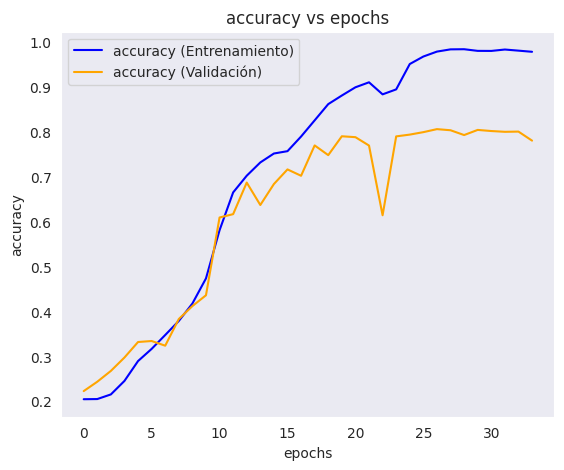

In [ ]:
# Extraer los datos del historial
epochs = history1.epoch  # Lista de épocas
accuracy = history1.history['accuracy']  # Precisión en entrenamiento
val_accuracy = history1.history['val_accuracy']  # Precisión en validación
loss = history1.history['loss']  # Pérdida en entrenamiento
val_loss = history1.history['val_loss']  # Pérdida en validación

# Graficar Precisión
plt.figure(figsize=(14, 5))  # Establecer el tamaño de la figura

plt.subplot(1, 2, 1)  # Crear un subplot (1 fila, 2 columnas, primer gráfico)
plt.plot(epochs, accuracy, label='accuracy (Entrenamiento)', color='blue')  # Graficar precisión de entrenamiento
plt.plot(epochs, val_accuracy, label='accuracy (Validación)', color='orange')  # Graficar precisión de validación
plt.title('accuracy vs epochs')  # Título del gráfico
plt.xlabel('epochs')  # Etiqueta del eje x
plt.ylabel('accuracy')  # Etiqueta del eje y
plt.legend()  # Mostrar leyenda
plt.grid()  # Mostrar cuadrícula en el gráfico

Al inicio del entrenamiento (primeras épocas), tanto la pérdida de entrenamiento como la de validación disminuyen rápidamente, lo que indica que el modelo está aprendiendo de manera efectiva. Sin embargo, a partir de cierta época (alrededor de 15), la pérdida de validación comienza a aumentar ligeramente, mientras que la pérdida de entrenamiento continúa disminuyendo. Esto sugiere que el modelo podría estar sobreajustándose a los datos de entrenamiento, es decir, está aprendiendo los detalles específicos de esos datos en lugar de las características generales que le permitirían generalizar a nuevos datos. Aunque es intersante ver la caida de la perdida en validacion, siendo huella de que el modelo empezo muy mal y fue mejorando. Afortunadamente la matriz de confusion no presento tantos signos de sobre ajuste.

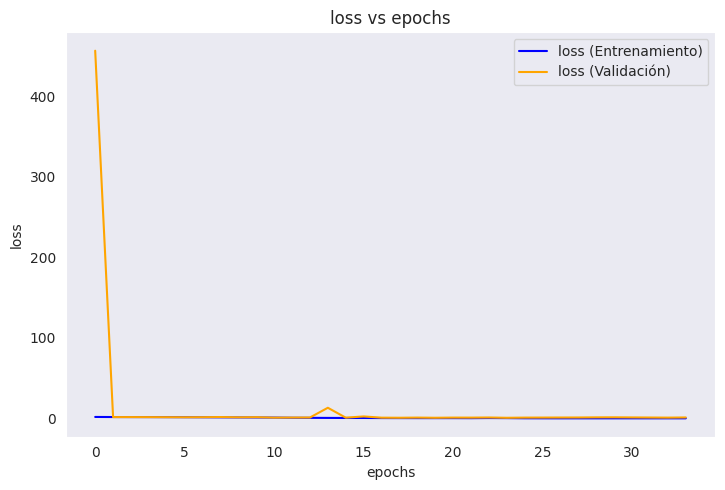

In [ ]:
plt.subplot(1, 2, 2)  # Crear un subplot (1 fila, 2 columnas, segundo gráfico)
plt.plot(epochs, loss, label='loss (Entrenamiento)', color='blue')  # Graficar pérdida de entrenamiento
plt.plot(epochs, val_loss, label='loss (Validación)', color='orange')  # Graficar pérdida de validación
plt.title('loss vs epochs')  # Título del gráfico
plt.xlabel('epochs')  # Etiqueta del eje x
plt.ylabel('loss')  # Etiqueta del eje y
plt.legend()  # Mostrar leyenda
plt.grid()  # Mostrar cuadrícula en el gráfico

plt.tight_layout()  # Ajustar el diseño para que no se superpongan los subgráficos
plt.show()  # Mostrar todos los gráficos

# **PREDICCIONES 1**

En esta parte podemos obtener una comprensión más profunda del rendimiento del modelo de clasificación. Al combinar la aleatoriedad en la selección de imágenes con la visualización de resultados, se facilita la identificación de fortalezas y debilidades del modelo. Esto es esencial para la validación y el ajuste continuo del modelo, asegurando que se logren resultados precisos y confiables en la clasificación de emociones en imágenes

Se observa varias emociones etiquetadas, como "felicidad" (Happy), "sorpresa" (Surprise), "neutralidad" (Neutral), "tristeza" (Sad) y "enojo" (Angry). La mayoría de las veces, el modelo logra identificar correctamente las emociones, con niveles de confianza muy altos, que van desde el 94% hasta el 100%. Esto sugiere que el modelo es bastante efectivo al interpretar las emociones faciales, especialmente en expresiones como felicidad, sorpresa y enojo, donde los aciertos alcanzan el 100% de confianza en varios casos. Este alto nivel de confianza en las predicciones exitosas indica que el modelo es competente en reconocer gestos y características faciales comunes para estas emociones específicas. Sin embargo, hay algunos casos donde el modelo parece tener dificultades para interpretar emociones más sutiles o ambiguas, como la neutralidad. En un par de ejemplos, la emoción verdadera es "neutral," pero el modelo la clasifica como "tristeza," con niveles de confianza bastante altos (alrededor del 97%), lo que sugiere una posible área de mejora.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


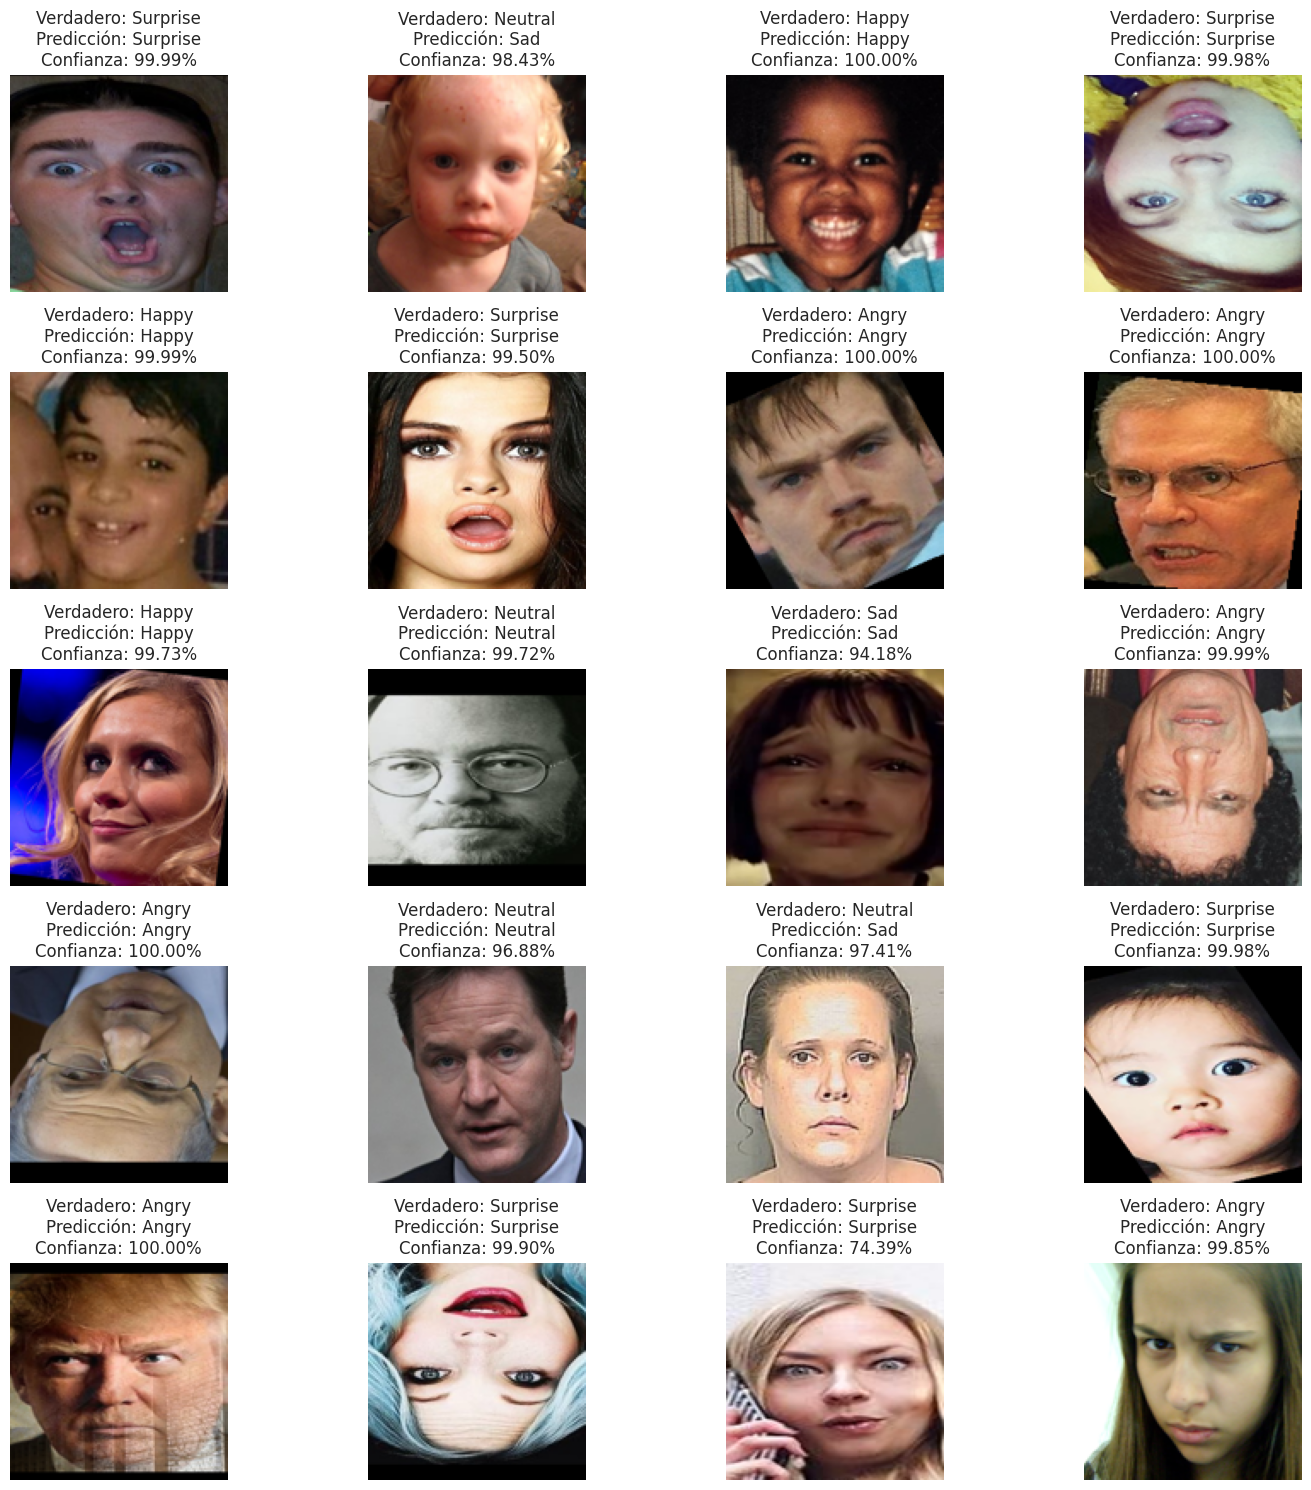

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Seleccionar aleatoriamente 20 índices de imágenes del conjunto de prueba
sample_indices = random.sample(range(len(x_test)), 20)  # Seleccionar 20 índices aleatorios

# Crear listas para almacenar las imágenes y las predicciones
sample_images = x_test[sample_indices]  # Obtener las imágenes correspondientes a los índices seleccionados
sample_true_labels = y_test[sample_indices]  # Obtener las etiquetas verdaderas correspondientes
sample_pred_labels = model.predict(sample_images)  # Hacer predicciones sobre las imágenes seleccionadas

# Convertir las predicciones a clases
predicted_classes = np.argmax(sample_pred_labels, axis=1)  # Obtener las clases predichas
true_classes = np.argmax(sample_true_labels, axis=1)  # Obtener las clases verdaderas

# Obtener los porcentajes de las predicciones
predicted_probabilities = np.max(sample_pred_labels, axis=1) * 100  # Convertir a porcentaje

# Crear un diccionario para las clases
class_labels = {0: 'Angry', 1: 'Happy', 2: 'Neutral', 3: 'Sad', 4: 'Surprise'}  # Etiquetas de las clases

# Visualizar las imágenes con sus etiquetas verdaderas y predicciones
plt.figure(figsize=(15, 15))  # Establecer el tamaño de la figura
for i, idx in enumerate(sample_indices):
    plt.subplot(5, 4, i + 1)  # Crear un subplot para cada imagen
    plt.imshow(sample_images[i])  # Mostrar la imagen
    plt.axis('off')  # Ocultar los ejes
    plt.title(f"Verdadero: {class_labels[true_classes[i]]}\n"  # Título con la etiqueta verdadera
              f"Predicción: {class_labels[predicted_classes[i]]}\n"  # Título con la predicción
              f"Confianza: {predicted_probabilities[i]:.2f}%")  # Título con la confianza de la predicción

plt.tight_layout()  # Ajustar el diseño para que no se superpongan los subgráficos
plt.show()  # Mostrar todas las imágenes

# **PREDICCIONES 2**

Acá nos enfocamos sobre la visualización, lo cual es extremadamente útil para la evaluación del rendimiento de un modelo de clasificación de emociones, ya que permite una comprensión más profunda de cómo el modelo se comporta frente a diferentes clases. La organización de las imágenes por clase verdadera facilita la identificación de áreas problemáticas, como confusiones entre emociones similares, y proporciona una visión clara de la efectividad del modelo. Al mostrar la confianza de las predicciones, se ofrece una perspectiva adicional sobre la fiabilidad del modelo, lo que puede guiar futuras mejoras y ajustes en el proceso de entrenamiento. En resumen, esta metodología no solo ayuda a validar el rendimiento del modelo, sino que también es una herramienta valiosa para la comunicación de resultados en el ámbito del aprendizaje automático

Las imágenes muestran resultados de un modelo de clasificación de emociones en rostros humanos, donde se presenta la etiqueta verdadera de la emoción (Verdadero), la predicción realizada por el modelo y la confianza de dicha predicción expresada en porcentaje. Las emociones clasificadas incluyen "Angry" (enojado), "Happy" (feliz), "Neutral" y "Sad" (triste), junto con "Surprise" (sorpresa). Cada imagen de rostro está acompañada por estos tres indicadores: la emoción real del individuo, la emoción predicha y el nivel de confianza del modelo en esa predicción. Los resultados muestran una alta precisión, ya que la predicción coincide con la etiqueta verdadera en la mayoría de los casos y con un porcentaje de confianza muy alto, generalmente cercano al 100%. Sin embargo, en algunas ocasiones hay una ligera discrepancia en la clasificación, como se ve en los casos donde la emoción verdadera es "Neutral" y se clasifica erróneamente como "Sad", aunque con confianza moderada (por debajo del 99%). Esto sugiere que el modelo está bien entrenado y es capaz de reconocer correctamente las emociones en la mayoría de los casos, pero también indica posibles limitaciones al distinguir entre emociones similares o sutilezas faciales en expresiones más neutras.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


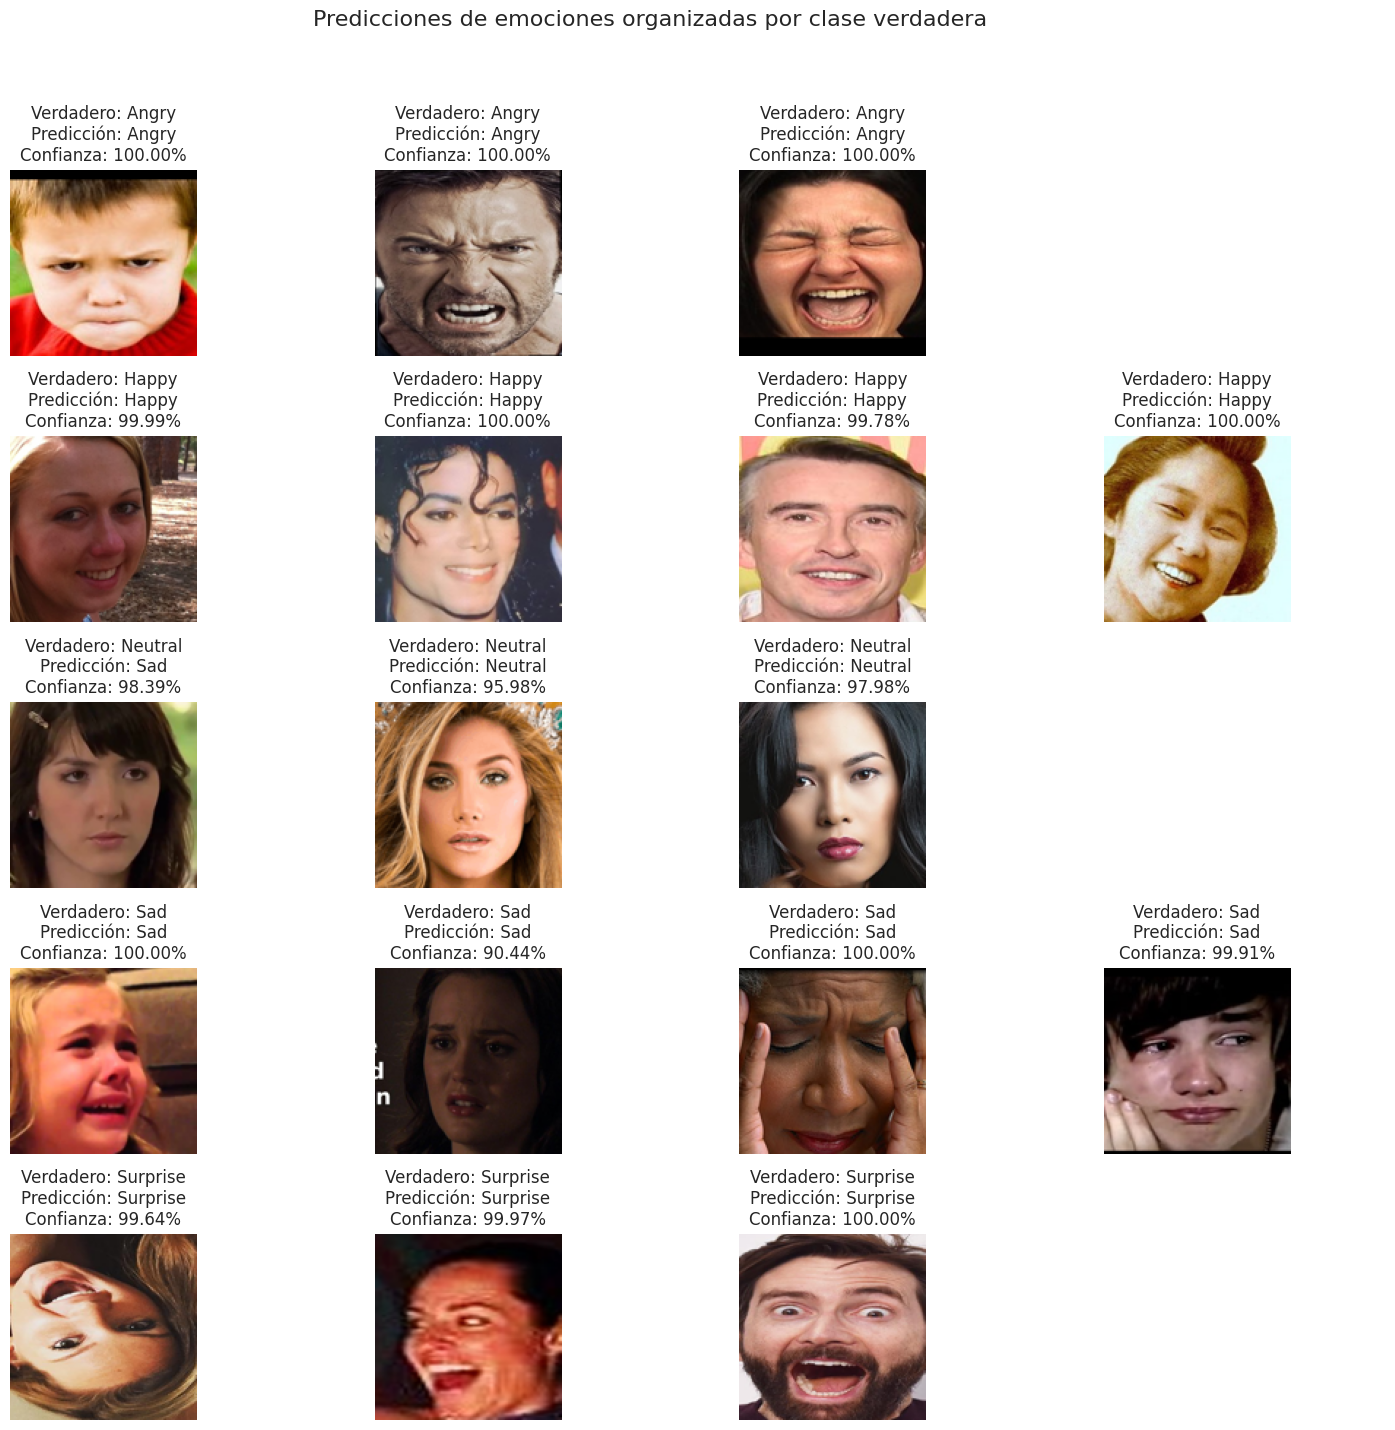

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Seleccionar aleatoriamente 20 índices de imágenes del conjunto de prueba
sample_indices = random.sample(range(len(x_test)), 20)  # Seleccionar 20 índices aleatorios

# Crear listas para almacenar las imágenes y las predicciones
sample_images = x_test[sample_indices]  # Obtener las imágenes correspondientes a los índices seleccionados
sample_true_labels = y_test[sample_indices]  # Obtener las etiquetas verdaderas correspondientes
sample_pred_labels = model.predict(sample_images)  # Hacer predicciones sobre las imágenes seleccionadas

# Convertir las predicciones a clases y obtener las clases verdaderas
predicted_classes = np.argmax(sample_pred_labels, axis=1)  # Obtener las clases predichas
true_classes = np.argmax(sample_true_labels, axis=1)  # Obtener las clases verdaderas

# Diccionario de clases
class_labels = {0: 'Angry', 1: 'Happy', 2: 'Neutral', 3: 'Sad', 4: 'Surprise'}  # Etiquetas de las clases

# Configurar la figura para 5 filas y 4 columnas
fig, axs = plt.subplots(5, 4, figsize=(15, 15))  # Crear subgráficos
fig.suptitle("Predicciones de emociones organizadas por clase verdadera", fontsize=16)  # Título general

# Filtrar y mostrar las imágenes por cada clase
for emotion_class, emotion_name in class_labels.items():
    # Encontrar las imágenes con la clase verdadera igual a la emoción actual
    emotion_indices = [i for i, true_class in enumerate(true_classes) if true_class == emotion_class]

    # Mostrar hasta 4 ejemplos para cada emoción
    for j in range(4):
        ax = axs[emotion_class, j]  # Ubicar en la fila correspondiente a la emoción actual

        if j < len(emotion_indices):
            idx = emotion_indices[j]  # Obtener el índice de la imagen
            # Mostrar la imagen
            ax.imshow(sample_images[idx])
            ax.axis('off')  # Ocultar los ejes

            # Título con emoción verdadera y predicción
            ax.set_title(f"Verdadero: {emotion_name}\n"  # Título con la etiqueta verdadera
                         f"Predicción: {class_labels[predicted_classes[idx]]}\n"  # Título con la predicción
                         f"Confianza: {np.max(sample_pred_labels[idx]) * 100:.2f}%")  # Título con la confianza de la predicción
        else:
            ax.axis('off')  # Apagar el eje si no hay suficientes imágenes en la clase

# Ajustar el diseño
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Dejar espacio para el título general
plt.show()  # Mostrar todas las imágenes